In [35]:
from importlib import reload
import numpy as np
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import tensorflow as tf
from tensorflow.keras import layers

In [91]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from 'C:\\Users\\Andrew\\Documents\\mlprojects\\781-piano-autoencoder\\src\\ml_classes.py'>

In [33]:
with open('model_datas_non_sparse_base_key_03-04', 'wb') as f:
    pickle.dump(model_datas, f)
# for md in model_datas:
#     with open('training_data/' + md.name + 'v0', 'wb') as f:
#         pickle.dump(md.data, f)

In [92]:
model_datas = data.folder2examples('training_data\midi_train', sparse=True, use_base_key=True, beats_per_ex=16)
# with open('H2', 'wb') as f:
#     pickle.dump(mode_datas, f)

processing file 0 of 16
processing file 10 of 16
02h 15m 03s of training data
(64, 88)
(64, 88)
(64, 88)
(64, 88)
(64, 2)
(12,)
(1,)
(1,)


## Model Construction
The 'model data' datatype provides information about inputs/outputs such as name, dimension, and whether or not it is sequential. So why this step here, using named tuples to provide information about inputs and outputs for model construction?  
Sometimes data is used as both input and output, and then a single label can't be applied. If data is not for an output, then activation is an irrelevant attribute.  
It probably maybe would still make sense to incorporate input/output and all other relevant info into the model data dtype, and then these *could* be passed into methods that construct models.

In [97]:
n_notes=88
# I assume that data, aside from the sequential dimentsion, will never have more than 1 dimension
model_input = namedtuple('input', 'name dim seq')
model_output = namedtuple('output', 'name dim activation seq')

# model input requirements
model_input_reqs_unfiltered = [model_input('H', n_notes, True),
                               model_input('tempo', 1, False),
                               model_input('key', 12, False),
                               model_input('V_mean', 1, False)]

# model output requirements
model_output_reqs_unfiltered = [model_output('H', n_notes, 'sigmoid', True),
                                model_output('O', n_notes, 'tanh', True),
                                model_output('V', n_notes, 'sigmoid', True)]

input 0: H
input 1: V_mean
out 0: V


### Simple Bidirectional LSTM Network

Model: "simple_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
V_mean_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 64, 88)]     0                                            
__________________________________________________________________________________________________
repeat64Times (RepeatVector)    (None, 64, 1)        0           V_mean_in[0][0]                  
__________________________________________________________________________________________________
joinModelInput (Concatenate)    (None, 64, 89)       0           H_in[0][0]                       
                                                                 repeat64Times[0][0]    

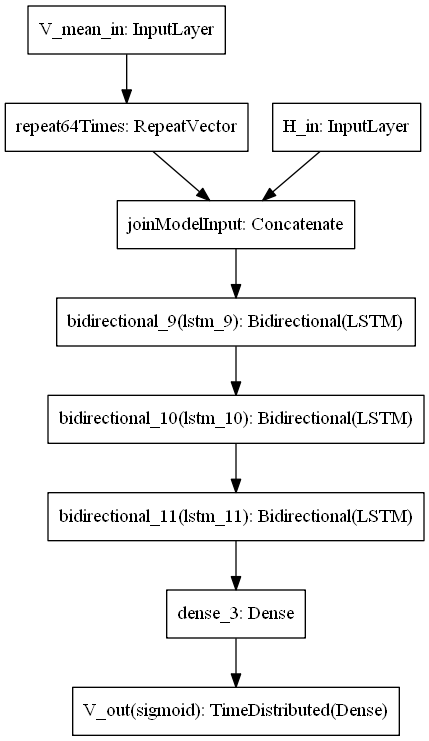

In [98]:
model_inputs = ['H', 'V_mean']
model_outputs = ['V']
model_input_reqs = [m_input for m_input in model_input_reqs_unfiltered if m_input.name in model_inputs]
model_output_reqs = [m_output for m_output in model_output_reqs_unfiltered if m_output.name in model_outputs]
seq_length = 64
seq_model = models.create_simple_LSTM_RNN(model_input_reqs, model_output_reqs, seq_length=seq_length)
seq_model.summary()
tf.keras.utils.plot_model(seq_model)

In [99]:
model_inputs = ['H', 'V_mean']
model_outputs = ['V']
model_input_reqs = [m_input for m_input in model_input_reqs_unfiltered if m_input.name in model_inputs]
model_output_reqs = [m_output for m_output in model_output_reqs_unfiltered if m_output.name in model_outputs]
for i, model_input in enumerate(model_input_reqs):
    print(f'input {i}: {model_input.name}')
          
for i, model_output in enumerate(model_output_reqs):
    print(f'out {i}: {model_output.name}')
dg = ml_classes.ModelDataGenerator([md for md in model_datas.values()],
                                   [model_in.name for model_in in model_input_reqs],
                                   [model_out.name for model_out in model_output_reqs],
                                    t_force=False, batch_size = 30, seq_length=seq_length)
seq_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = seq_model.fit_generator(dg, epochs=1, verbose=1)

18/18 [==============================] - 99s 6s/step - loss: 1.7469 - accuracy: 0.0183


### Simple LSTM encoder decoder

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tempo_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
key_in (InputLayer)             [(None, 12)]         0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 64, 88)]     0                                            
__________________________________________________________________________________________________
repeat64Times (RepeatVector)    multiple             0           tempo_in[0][0]                   
                                                                 key_in[0][0]           

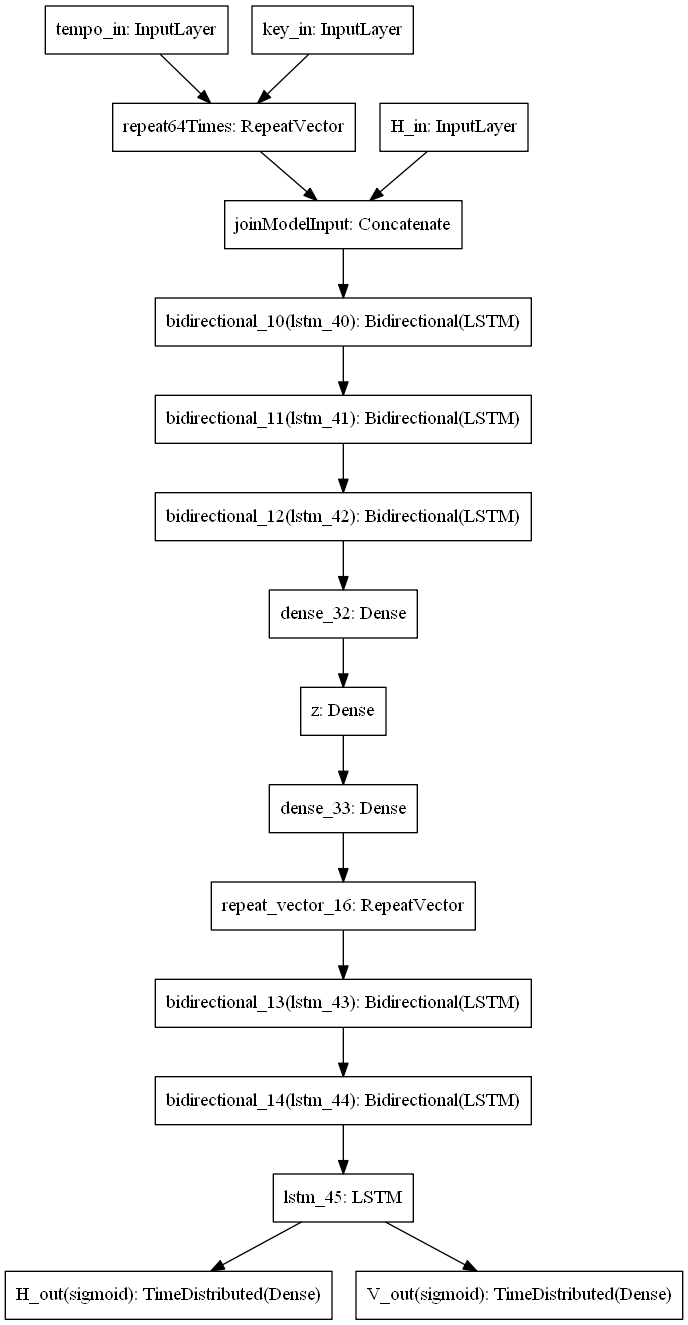

In [51]:
z, model_inputs = models.create_LSTMencoder_graph(model_input_reqs)
pred = models.create_LSTMdecoder(z, model_outputs, seq_length=seq_length, hidden_state_size = 64,
                    dense_size = 64)

autoencoder = tf.keras.Model(inputs=model_inputs, outputs=pred, name=f'autoencoder')
autoencoder.summary()
tf.keras.utils.plot_model(autoencoder)

In [55]:
dg = ml_classes.ModelDataGenerator([md for md in model_datas.values()], [model_in.name for model_in in model_inputs], [model_out.name for model_out in model_outputs], batch_size = 30, seq_length=seq_length)
test_autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = test_autoencoder.fit_generator(dg, epochs=3, verbose=1)


Epoch 1/3
18/18 [==============================] - 89s 5s/step - loss: 4.8473 - H_out_loss: 3.6273 - V_out_loss: 1.2200 - H_out_accuracy: 0.0119 - V_out_accuracy: 0.0078
Epoch 2/3
18/18 [==============================] - 96s 5s/step - loss: 4.7893 - H_out_loss: 3.5831 - V_out_loss: 1.2062 - H_out_accuracy: 0.0100 - V_out_accuracy: 0.0080
Epoch 3/3
18/18 [==============================] - 97s 5s/step - loss: 4.7460 - H_out_loss: 3.5520 - V_out_loss: 1.1941 - H_out_accuracy: 0.0086 - V_out_accuracy: 0.0103


### Hierarchical Encoder Decoder
Notice the need for the dummy input. This is because LSTMs operate for the number of time steps in the input - but there actually isn't any input for some of the LSTMs in this model.

conductor substeps: 8
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tempo_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
key_in (InputLayer)             [(None, 12)]         0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 64, 88)]     0                                            
__________________________________________________________________________________________________
repeat64Times (RepeatVector)    multiple             0           tempo_in[0][0]                   
                                                                 key_i

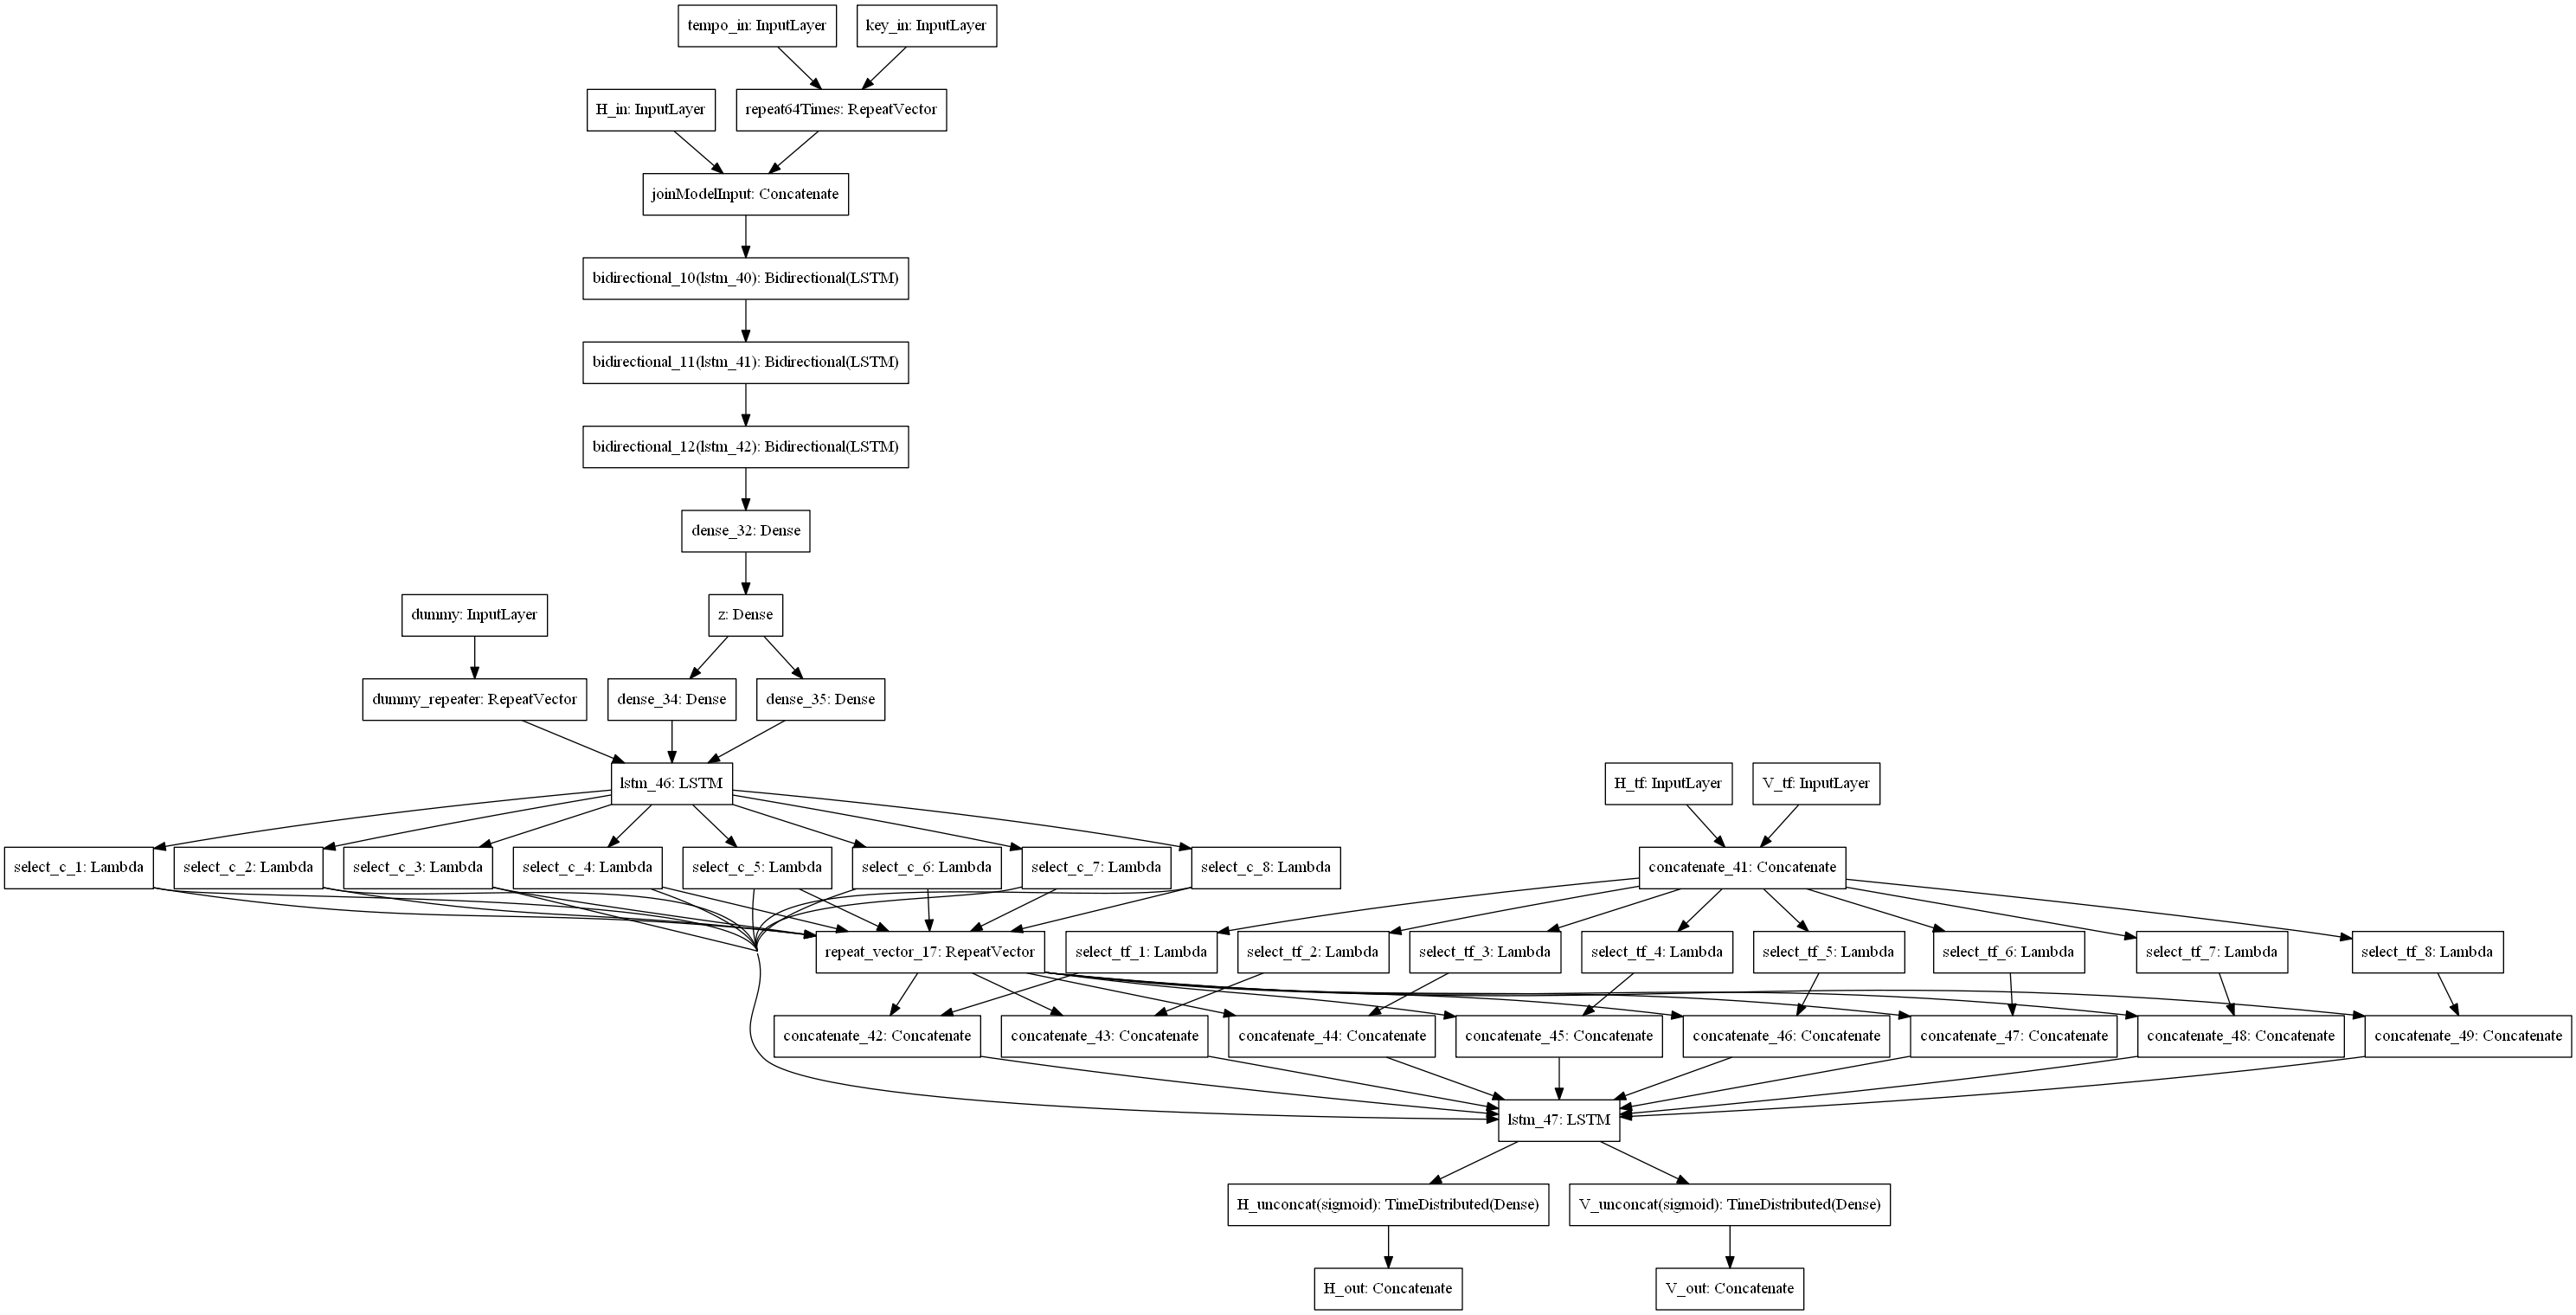

In [52]:
z, model_inputs = models.create_LSTMencoder_graph(model_input_reqs)
dummy = tf.keras.Input(shape=[0], name='dummy')
outputs, extra_inputs = models.create_hierarchical_decoder_graph(z, model_output_reqs, dummy)
test_autoencoder = tf.keras.Model(inputs=model_inputs + extra_inputs, outputs=outputs)
test_autoencoder.summary()
tf.keras.utils.plot_model(test_autoencoder)

In [ ]:
# An autoencoder with separate encoder + decoder models might look like this:
inputA = tf.keras.Input((5,2), name='input_a')
outputA = layers.LSTM(5)(inputA)
modelA = tf.keras.Model(inputA, outputA)

inputB = tf.keras.Input(5, name='input_b')
outputB = layers.Dense(5)(inputB)
modelB = tf.keras.Model(inputB, outputB)

inputC = tf.keras.Input((5,2))
encoded = modelA(inputC)
decoded = modelB(encoded)
modelC = tf.keras.Model(inputC, decoded)
modelC.summary()